## 1. Import Library
___

In [1]:
import os
import random
import numpy as np 
import pandas as pd
import gc

from glob import glob
from tqdm import tqdm
import pickle 

import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

from PIL import Image
import cv2

import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

#### Configuration

In [2]:
class CFG:
    debug = False
    output_dir = 'runs/predict'

    seed = 42
    img_size = [256,256]
    input_format = 'RGB'
    imgdir = '/kaggle/input/colonoscopy-256x256-resized-png'

    ims_per_batch = 8
    num_workers = 4

    model_name = 'MViTv2_T' ## Tiny Version

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.makedirs(CFG.output_dir, exist_ok=True)

#### Install Detectron2 Library

In [3]:
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.3 MB/s eta 0:00:00


## 2. Utils
___

In [4]:
def format_pred(labels, boxes, scores):
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.float32)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)

In [5]:
def string_decoder(predict_string):
    s = predict_string.split(' ')
    class_id = [x for x in (s[0::6])]
    score = [x for x in (s[1::6])]
    x_min = [x for x in (s[2::6])]
    y_min = [x for x in (s[3::6])]
    x_max = [x for x in (s[4::6])]
    y_max = [x for x in (s[5::6])]

    return class_id, score, x_min, y_min, x_max, y_max

In [6]:
!pip install -q map-boxes
from map_boxes import mean_average_precision_for_boxes

Couldn't import fast version of function compute_overlap, will use slow one. Check cython intallation


## 3. Build Dataset_dicts
___

- **궤양**: `ulcer(label: 0)`

- **용종**: `polyp(label: 1)`

- **암**: `cancer(label: 2)`

In [7]:
meta_data = pd.read_csv('/kaggle/input/metadataset/colonoscopy_data2.csv')
print('Shape of DataFrame: ', meta_data.shape)
meta_data.head()

Shape of DataFrame:  (2496, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1484.52,775.16;1516.82,710.56;1519.30,640.99;1...",rectangle,838.559006,149.068323,1519.304348,807.453416,ulcer
1,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1663.40,1478.26;1653.47,1426.09;1616.20,1388.8...",rectangle,1310.608696,1324.223602,1663.403727,1868.322981,ulcer
2,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"687.01,223.60;687.01,273.29;704.40,337.89;726....",rectangle,687.006211,168.944099,1591.354037,1465.838509,ulcer
3,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"826.14,1200.00;878.31,1207.45;932.97,1187.58;9...",rectangle,488.248447,434.782609,1007.503106,1207.453416,ulcer
4,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"575.20,1038.51;520.55,1050.93;468.37,1050.93;4...",rectangle,212.472050,725.465839,607.503106,1050.931677,ulcer


In [8]:
thing_classes = [
    'Ulcer',
    'Polyp',
    'Cancer',
]

category_id_to_name = {index: class_name for index,class_name in enumerate(thing_classes) }

meta_data['lesion'] = meta_data['lesion_label'].map(category_id_to_name)

In [9]:
test_id = [x.split('/')[-1] for x in glob('/kaggle/input/colonoscopy-256x256-resized-png/test/*.png')] 
test_df = meta_data[meta_data['image_id'].isin(test_id)]
test_df = test_df.sort_values(by='image_id').reset_index(drop=True)

In [10]:
from detectron2.structures import BoxMode

def get_colonoscopy_dicts(
    imgdir,
    df,
    mode = 'test',
    use_cache=True,
    debug = True,
    target_indices = None
):
    debug_str = f'_debug{int(debug)}'
    cache_path = f'/kaggle/working/dataset_dicts_cache_{mode}{debug_str}.pkl'
    
    if not use_cache or not os.path.exists(cache_path):
       print(f'{Fore.RED}#'* 25)
       print(f'### Creating {mode} Data...')
       print('#' * 25)

       meta_df = pd.read_csv(f'/kaggle/input/colonoscopy-256x256-resized-png/{mode}_meta.csv')

       if debug:
           meta_df = meta_df[:500]

       image_id = meta_df.loc[0,'image_id']
       image_path = os.path.join(imgdir,mode, image_id)
       image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
       resized_height, resized_width, channel = image.shape
       print(f'=> Height of Image: {resized_height}')
       print(f'=> Width of Image: {resized_width}')

       dataset_dicts = []
       for _, (image_id, height, width) in tqdm(meta_df.iterrows(), total=len(meta_df), desc='Build Dataset Dict'):
           record = {}
           record['file_name'] = os.path.join(imgdir,mode,image_id)
           record['image_id'] = image_id
           record['height'] = resized_height
           record['width'] = resized_width

           objs = []
           for _, row in df[df.image_id == image_id].iterrows():
               class_id = row['lesion_label']

               h_ratio = resized_height / height
               w_ratio = resized_width / width

               bbox_resized = [
                      row['x_min'] * w_ratio,
                      row['y_min'] * h_ratio,
                      row['x_max'] * w_ratio,
                      row['y_max'] * h_ratio,
                  ]

               obj = {
                     'bbox': bbox_resized,
                     'bbox_mode': BoxMode.XYXY_ABS,
                     'category_id': class_id,
                  }
               objs.append(obj)
               
           record['annotations'] = objs
           dataset_dicts.append(record)
           
       with open(cache_path, mode='wb') as f:
           pickle.dump(dataset_dicts, f)

    with open(cache_path, mode='rb') as f:
        dataset_dicts = pickle.load(f)

    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

In [11]:
import detectron2
from detectron2.data import DatasetCatalog, MetadataCatalog

In [12]:
DatasetCatalog.register(
    'colonoscopy_test',
     lambda: get_colonoscopy_dicts(CFG.imgdir, test_df, mode='test', debug=CFG.debug)
)

MetadataCatalog.get('colonoscopy_test').set(thing_classes=thing_classes)

namespace(name='colonoscopy_test', thing_classes=['Ulcer', 'Polyp', 'Cancer'])

In [13]:
dataset_dicts = DatasetCatalog.get('colonoscopy_test')

#########################
### Creating test Data...
#########################
=> Height of Image: 256
=> Width of Image: 256


Build Dataset Dict: 100%|██████████| 400/400 [00:00<00:00, 1582.66it/s]


## 4. Model Config Setting

In [14]:
from detectron2 import model_zoo 
from detectron2.config import get_cfg, LazyConfig, instantiate
from detectron2.config import LazyCall as L
from detectron2.modeling import MViT
from omegaconf import OmegaConf
from functools import partial
import detectron2.data.transforms as T

In [15]:
from detectron2.evaluation import (
     COCOEvaluator,
     inference_on_dataset)

from detectron2.data import (
    build_detection_test_loader,
    DatasetMapper,
    get_detection_dataset_dicts)

from detectron2.checkpoint import DetectionCheckpointer

In [16]:
import logging
from functools import partial
from fvcore.common.param_scheduler import MultiStepParamScheduler, CosineParamScheduler

from omegaconf import OmegaConf

from detectron2.layers import ShapeSpec

from detectron2 import model_zoo 
from detectron2.config import get_cfg, LazyConfig, instantiate
from detectron2.config import LazyCall as L

from detectron2.data import (
    build_detection_train_loader, 
    build_detection_test_loader,
    DatasetMapper,
    get_detection_dataset_dicts)

from detectron2.evaluation import (
     COCOEvaluator,
     inference_on_dataset, 
     print_csv_format)

from detectron2.engine import (
     create_ddp_model,
     AMPTrainer, SimpleTrainer,
     default_argument_parser, default_setup, default_writers,
     hooks, launch ## DDP 
)
from detectron2.modeling.meta_arch import GeneralizedRCNN
from detectron2.modeling.anchor_generator import DefaultAnchorGenerator
from detectron2.modeling.backbone.fpn import LastLevelMaxPool
from detectron2.modeling.backbone import BasicStem, FPN, ResNet
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.modeling.matcher import Matcher
from detectron2.modeling.poolers import ROIPooler
from detectron2.modeling.proposal_generator import RPN, StandardRPNHead
from detectron2.modeling.roi_heads import (
    StandardROIHeads,
    FastRCNNOutputLayers,
    MaskRCNNConvUpsampleHead,
    FastRCNNConvFCHead,
    CascadeROIHeads
)

from detectron2.solver import WarmupParamScheduler
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import MViT

from detectron2.utils import comm
from detectron2.utils.logger import setup_logger

setup_logger()

<_Logger detectron2 (DEBUG)>

In [17]:
"""Model LazyConfig"""
model = model_zoo.get_config("common/models/mask_rcnn_fpn.py").model
constants = model_zoo.get_config("common/data/constants.py").constants
model.input_format = CFG.input_format
model.pixel_mean = constants.imagenet_rgb256_mean
model.pixel_std = constants.imagenet_rgb256_std

model.backbone.bottom_up = L(MViT)(
img_size = CFG.img_size[0],
patch_kernel=(7, 7), 
patch_stride=(4, 4), 
patch_padding=(3, 3),
embed_dim=96,
depth=10, # Depth of MViT
num_heads=1, # Number of base attention heads in each MViT block
last_block_indexes=(0, 2, 7, 9),
residual_pooling=True,
drop_path_rate=0.0,
norm_layer=partial(nn.LayerNorm, eps=1e-6),
pretrain_img_size=CFG.img_size[0],
pretrain_use_cls_token=True,
out_features=("scale2", "scale3", "scale4", "scale5"),
    )
model.backbone.in_features = "${.bottom_up.out_features}"
model.backbone.out_channels = 256
   

"""RPN 설정"""
model.proposal_generator.in_features=["p2", "p3", "p4", "p5", "p6"]
model.proposal_generator.head=L(StandardRPNHead)(in_channels=256, num_anchors=4)
model.proposal_generator.anchor_generator = L(DefaultAnchorGenerator)(
        sizes=[[32], [64], [128], [256], [512]],
        aspect_ratios=[0.5, 1.0, 2.0, 2.5],
        strides=[4, 8, 16, 32, 64],
        offset=0.5
    )
model.proposal_generator.anchor_matcher = L(Matcher)(
        thresholds=[0.3, 0.7], labels=[0, -1, 1], allow_low_quality_matches=True
    )
model.proposal_generator.box2box_transform = L(Box2BoxTransform)(weights=[1.0, 1.0, 1.0, 1.0])
model.proposal_generator.batch_size_per_image = 256
model.proposal_generator.positive_fraction = 0.5
model.proposal_generator.pre_nms_topk = (2000, 1000)
model.proposal_generator.post_nms_topk = (1000, 1000)
model.proposal_generator.nms_thresh = 0.7

"""ROI 설정"""
model.roi_heads.num_classes = len(thing_classes)
model.roi_heads.batch_size_per_image = 256
model.roi_heads.positive_fraction = 0.25
model.roi_heads.box_in_features = ["p2", "p3", "p4", "p5"]
model.roi_heads.box_pooler = L(ROIPooler)(
        output_size=7,
        scales=(1.0 / 4, 1.0 / 8, 1.0 / 16, 1.0 / 32),
        sampling_ratio=0,
        pooler_type="ROIAlignV2"
    )
model.roi_heads.box_head = L(FastRCNNConvFCHead)(
        input_shape=ShapeSpec(channels=256, height=7, width=7),
        conv_dims=[],
        fc_dims=[1024, 1024]
    )
model.roi_heads.box_predictor = L(FastRCNNOutputLayers)(
        input_shape=ShapeSpec(channels=1024),
        test_score_thresh=0.00,
        box2box_transform=L(Box2BoxTransform)(weights=(10, 10, 5, 5)),
        num_classes="${..num_classes}"
    )


"""Config 저장"""
cfg = OmegaConf.create()
cfg.model = model


"""Mask-RCNN에서 Faster-RCNN으로 변경"""
del cfg.model.roi_heads.mask_in_features
del cfg.model.roi_heads.mask_pooler
del cfg.model.roi_heads.mask_head

## 5. Prediction Scripts
___

In [18]:
@torch.no_grad()
def predict_batch(model, im_list):
    inputs_list = []
    for original_image in im_list:
        original_image = original_image[:,:,::-1] ## BGR -> RGB 

        height = CFG.img_size[1]
        width = CFG.img_size[0]
        image = cv2.resize(original_image, (width, height))
        image = torch.as_tensor(image.astype('float32').transpose(2,0,1))
        image.to(CFG.device)
        inputs = {'image': image, 'height': height, 'width': width}

        inputs_list.append(inputs)

    with torch.no_grad(): 
        predictions = model(inputs_list)
    return predictions

In [19]:
test_meta = pd.read_csv('/kaggle/input/colonoscopy-256x256-resized-png/test_meta.csv')

model = instantiate(cfg.model)
DetectionCheckpointer(model, save_dir=CFG.output_dir).resume_or_load(
            '/kaggle/input/colonoscopy-mvidet/runs/detect/model_final.pth', resume=False
        )
model.to(CFG.device)
model.eval()

result_list = []
index = 0
batch_size = 8

for i in tqdm(range(int(np.ceil(len(dataset_dicts)/batch_size)))):
    inds = list(range(batch_size * i, min(batch_size * (i+1), len(dataset_dicts))))
    dataset_dicts_batch = [dataset_dicts[i] for i in inds]
    im_list = [cv2.imread(d['file_name'], cv2.IMREAD_UNCHANGED) for d in dataset_dicts_batch]
    outputs_list = predict_batch(model, im_list)

    for j, (im,outputs,d) in enumerate(zip(im_list, outputs_list, dataset_dicts_batch)):
        resized_height = CFG.img_size[1]
        resized_width = CFG.img_size[0]


        image_id, height, width = test_meta.iloc[index].values
        
        instances = outputs['instances']
        fields = instances.get_fields()
        
        pred_classes = fields['pred_classes'].cpu().numpy()
        pred_scores = fields['scores'].cpu().numpy()
        pred_boxes = fields['pred_boxes'].tensor.cpu().numpy()

        h_ratio = height / resized_height
        w_ratio = width / resized_width

        pred_boxes[:,[0,2]] *= w_ratio
        pred_boxes[:,[1,3]] *= h_ratio
        
        result = {'image_id': image_id, 'PredictionString':
                 format_pred(pred_classes, pred_boxes, pred_scores)}
        
        result_list.append(result)
        index += 1

torch.cuda.empty_cache()
gc.collect()
del model

[03/05 00:30:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/input/colonoscopy-mvidet/runs/detect/model_final.pth ...


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


In [20]:
submission_det = pd.DataFrame(result_list, columns=['image_id','PredictionString'])
submission_det.to_csv('/kaggle/working/submission.csv', index=False)
display(submission_det)

,image_id,PredictionString
0,2_1_00002.png,0 0.9952043294906616 678.1111450195312 280.574...
1,2_1_00004.png,0 0.9965127110481262 437.4851379394531 570.012...
2,2_1_00006.png,0 0.9619913697242737 1356.9383544921875 529.86...
3,2_1_00007.png,0 0.9994975328445435 930.1696166992188 532.501...
4,2_1_00048.png,0 0.9992467164993286 592.1744995117188 280.653...
...,...,...
395,2_3_10237.png,1 0.9997314810752869 1188.0911865234375 817.45...
396,2_3_10243.png,2 0.7744365334510803 615.3096923828125 573.583...
397,2_3_10247.png,2 0.9998000264167786 71.90081787109375 236.390...
398,2_3_10251.png,2 0.9999936819076538 453.815673828125 813.4550...


## 5. Visualize predict
___

In [21]:
from detectron2.utils.visualizer import Visualizer

colonoscopy_metadata = MetadataCatalog.get('colonoscopy_test')
print(colonoscopy_metadata)

Metadata(name='colonoscopy_test', thing_classes=['Ulcer', 'Polyp', 'Cancer'])


[03/05 00:30:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/input/colonoscopy-mvidet/runs/detect/model_final.pth ...


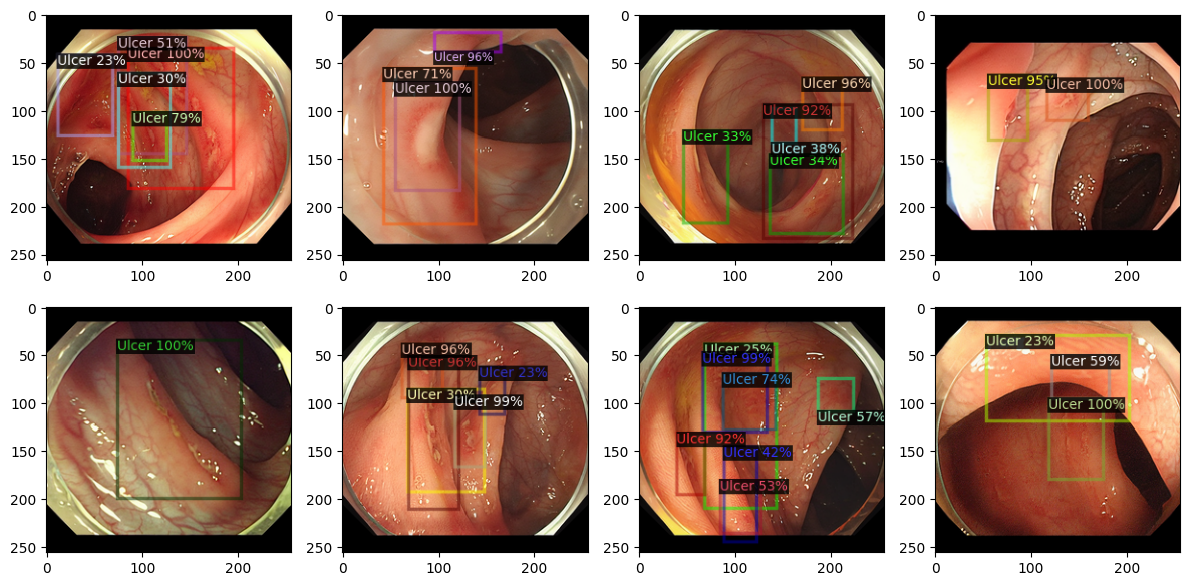

41477

In [22]:
cfg.model.roi_heads.box_predictor.test_score_thresh = 0.2

model = instantiate(cfg.model)
DetectionCheckpointer(model, save_dir=CFG.output_dir).resume_or_load(
            '/kaggle/input/colonoscopy-mvidet/runs/detect/model_final.pth', resume=False
        )
model.to(CFG.device)
model.eval()

image_id = test_df['image_id'].unique()

plt.style.use('default')
plt.figure(figsize=(12,6))

for i in range(8):
    plt.subplot(2,4,i+1)
    path = f'/kaggle/input/colonoscopy-256x256-resized-png/test/{image_id[i]}'
    inputs = cv2.imread(path); inputs = cv2.resize(inputs, (CFG.img_size[0], CFG.img_size[0])) 
    inputs = inputs[:,:,::-1]

    visualizer = Visualizer(inputs, metadata=colonoscopy_metadata, scale=1.0)
    
    image = torch.as_tensor(inputs.astype('float32').transpose(2,0,1))
    image.to(CFG.device)
    inputs = [{'image': image, 'height': CFG.img_size[1], 'width': CFG.img_size[0]}]

    with torch.no_grad(): 
        output = model(inputs)
    
    out = visualizer.draw_instance_predictions(output[0]['instances'].to('cpu'))
    plt.imshow(out.get_image())
    # plt.axis('off')
    

plt.tight_layout()
plt.show()

torch.cuda.empty_cache()
gc.collect()

## 7. Evaluation
___

### Method1: map-boxes

In [23]:
submission_list = []

for i, row in tqdm(submission_det.iterrows(), total=len(submission_det)):
    image_id = row['image_id']
    string_decoded = string_decoder(row['PredictionString'])

    for  (class_id, score, xmin, ymin, xmax, ymax) in zip(*string_decoded):
        submission_list.append(
            {
                'image_id': image_id,
                'lesion_label': int(class_id),
                'score': float(score),
                'x_min': float(xmin),
                'y_min': float(ymin),
                'x_max': float(xmax),
                'y_max': float(ymax),
                }
        )

submission_metric = pd.DataFrame(submission_list, columns=['image_id', 'lesion_label', 'score','x_min','y_min', 'x_max', 'y_max'])

100%|██████████| 400/400 [00:00<00:00, 2653.72it/s]


In [24]:
ann = test_df.copy()
det = submission_metric.copy()

ann = ann[['image_id','lesion_label','x_min','x_max','y_min','y_max']].values

det = det[['image_id','lesion_label', 'score','x_min','x_max','y_min','y_max']].values

mean_ap_50, average_precisions_50 = mean_average_precision_for_boxes(ann, det, iou_threshold=0.5)
mean_ap_75, average_precisions_75 = mean_average_precision_for_boxes(ann, det, iou_threshold=0.75)


Number of files in annotations: 400
Number of files in predictions: 400
Unique classes: 3
Detections length: 400
Annotations length: 400
0                              | 0.423020 |     180
1                              | 0.719574 |     116
2                              | 0.857101 |     200
mAP: 0.666565
Number of files in annotations: 400
Number of files in predictions: 400
Unique classes: 3
Detections length: 400
Annotations length: 400
0                              | 0.046908 |     180
1                              | 0.447107 |     116
2                              | 0.559925 |     200
mAP: 0.351313


### Method2: Detectron2 Evaluation
___

In [25]:
cfg.model.roi_heads.box_predictor.test_score_thresh = 0.0

evaluator = COCOEvaluator("colonoscopy_test", ("bbox",), False, output_dir=os.path.join(CFG.output_dir, 'inference'))

test_loader = build_detection_test_loader(
      dataset = get_detection_dataset_dicts(names='colonoscopy_test'),
      mapper=DatasetMapper(is_train=False, image_format=CFG.input_format,
                           augmentations = [T.ResizeScale(min_scale=1.0, 
                                                          max_scale=1.0, 
                                                          target_width=CFG.img_size[0],
                                                          target_height=CFG.img_size[1])]),
      batch_size = CFG.ims_per_batch,
      num_workers = CFG.num_workers,
      )

## Build and Load Model
model = instantiate(cfg.model)
DetectionCheckpointer(model, save_dir=CFG.output_dir).resume_or_load(
            '/kaggle/input/colonoscopy-mvidet/runs/detect/model_final.pth', resume=False
        )
model.to(CFG.device)
model.eval()

## Evaluate Metrics
result = inference_on_dataset(model, test_loader, evaluator)

[03/05 00:30:54 d2.evaluation.coco_evaluation]: Trying to convert 'colonoscopy_test' to COCO format ...
[03/05 00:30:54 d2.data.datasets.coco]: Converting annotations of dataset 'colonoscopy_test' to COCO format ...)
[03/05 00:30:54 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/05 00:30:54 d2.data.datasets.coco]: Conversion finished, #images: 400, #annotations: 496
[03/05 00:30:54 d2.data.datasets.coco]: Caching COCO format annotations at 'runs/predict/inference/colonoscopy_test_coco_format.json' ...
[03/05 00:30:54 d2.data.build]: Removed 0 images with no usable annotations. 400 images left.
[03/05 00:30:54 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   Ulcer    | 180          |   Polyp    | 116          |   Cancer   | 200          |
|            |              |       

In [26]:
!ls runs/predict/inference

"""instances_predictions.pth"""
## a file that can be loaded with 'torch.load'
## contains all the results in the format they are produced by the model 
## output format: pascal_voc(xmin, ymin, xmax, ymax)

"""coco_instances_results.json"""
## a json file in CoCo's result format 
## max_dets_per_image: limit on the maximum number of detections per image
## By Default in COCO, this limit is to 100.

"""colonoscopy_test_coco_format.json"""
## a json file in Coco's test dataset format

coco_instances_results.json	   colonoscopy_test_coco_format.json.lock
colonoscopy_test_coco_format.json  instances_predictions.pth


'colonoscopy_test_coco_format.json'